Four classifiers across MBTI Axis

In [ ]:

# Data Analysis
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine Learning packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.cluster as cluster
from sklearn.manifold import TSNE

# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()

# To use the uploaded file, you might do:
import pandas as pd
data = pd.read_csv("mbti_1.csv")

Saving mbti_1.csv to mbti_1.csv


In [ ]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0

    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found')

    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')

    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')

    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J })
    data = data.join(data.apply (lambda row: get_types (row),axis=1))



In [ ]:
    data = data.join(data.apply (lambda row: get_types (row),axis=1))
print ("Introversion (I) / Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) / Extroversion (E):	 1999  /  6676
Intuition (N) / Sensing (S):		 1197  /  7478
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


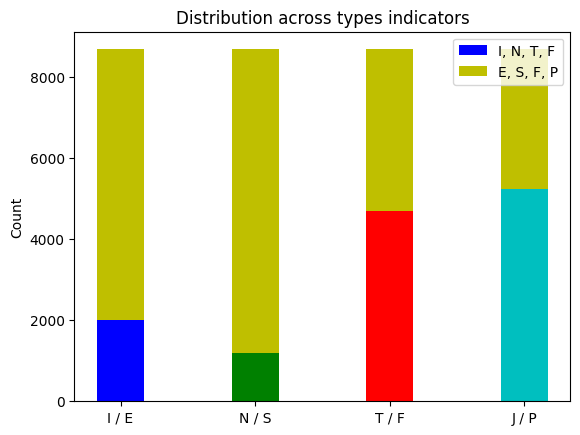

In [ ]:


# Your data
N = 4
bottom = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)  # the x locations for the groups
width = 0.35  # the width of the bars

# Define colors for the bars
colors = ['b', 'g', 'r', 'c']

# Create the bar plots with specified colors
p1 = plt.bar(ind, bottom, width, color=colors, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, color='y', label="E, S, F, P")  # You can specify a single color for the second set of bars

plt.title('Distribution across types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E', 'N / S', 'T / F', 'J / P'))
plt.legend()

plt.show()


Features correlation clustermap

<Figure size 1000x400 with 0 Axes>

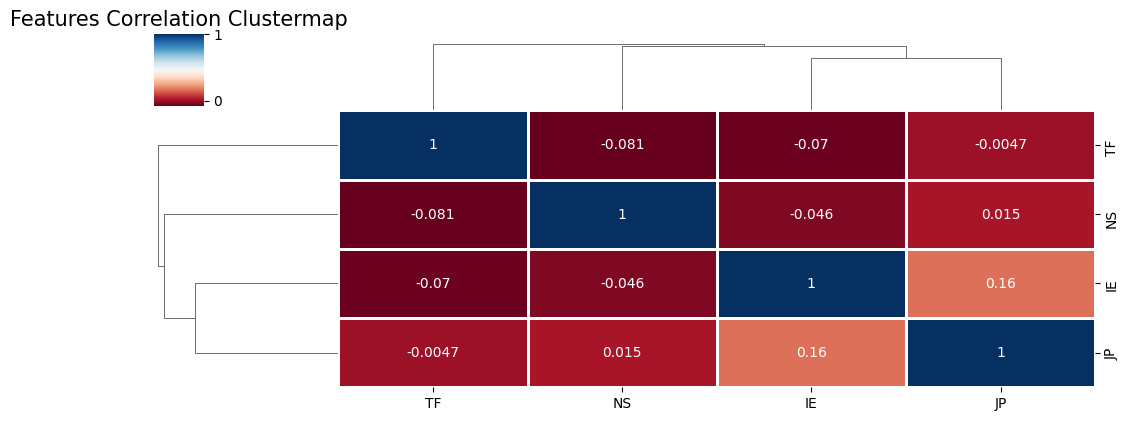

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cmap = plt.cm.RdBu
corr = data[['IE', 'NS', 'TF', 'JP']].corr()

plt.figure(figsize=(10, 4))
sns.clustermap(corr, cmap=cmap, annot=True, linewidths=1, figsize=(10 , 4))
plt.title('Features Correlation Clustermap', size=15)
plt.show()


Pre-processing stage


Lemmatization

In [ ]:
import nltk
nltk.download('stopwords')
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [b_Pers[l] for l in personality]

#To show result output for personality prediction
def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [ ]:
import nltk
nltk.download('wordnet')

def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
    list_personality = []
    list_posts = []
    len_data = len(data)
    i = 0

    for row in data.iterrows():
        # check code working
        # i += 1
        # if (i % 500 == 0 or i == 1 or i == len_data):
        #     print("%s of %s rows" % (i, len_data))

        # Remove and clean comments
        posts = row[1].posts

        # Remove url links
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

        # Remove Non-words - keep only words
        temp = re.sub("[^a-zA-Z]", " ", temp)

        # Remove spaces > 1
        temp = re.sub(' +', ' ', temp).lower()

        # Remove multiple letter repeating words
        temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

        # Remove stop words
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

        # Remove MBTI personality words from posts
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t, "")

        # transform mbti to binary vector
        type_labelized = translate_personality(row[1].type)  # or use lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)
        # the cleaned data temp is passed here
        list_posts.append(temp)

    # returns the result
    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

list_posts, list_personality = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])



[nltk_data] Downloading package wordnet to /root/nltk_data...


Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

Feature Engineering

In [ ]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word",
                             max_features=1000,
                             max_df=0.7,
                             min_df=0.1)
# the feature should be made of word n-gram
# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'act'), (5, 'action'), (6, 'actually'), (7, 'add'), (8, 'advice'), (9, 'afraid')]

Using Tf-idf :
Now the dataset size is as below
(8675, 595)


Splitting x and y

In [ ]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)",
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [ ]:
print("X: 1st posts in tf-idf representation\n%s" % X_tfidf[0])

X: 1st posts in tf-idf representation
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.08105478 0.07066064
 0.         0.         0.         0.         0.         0.
 0.         0.04516864 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05321691 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0871647  0.         0.         0.
 0.         0.         0.         0.05506308 0.0708757  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16585935 0.         0.         0.09676192 0.
 0.         0.04970682 0.         0.         0.         0.
 0.07397056 0.         0.         0.         0.         0.
 0.       

In [ ]:
print("For MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[0,:])

For MBTI personality type : INFJ
Y : Binarized MBTI 1st row: [0 0 0 0]


Training & Evaluating Models

In [ ]:
X = X_tfidf

In [ ]:
#Random Forest model for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.65%
NS: Intuition (N) / Sensing (S) Accuracy: 86.03%
FT: Feeling (F) / Thinking (T) Accuracy: 69.33%
JP: Judging (J) / Perceiving (P) Accuracy: 62.45%


In [ ]:
#XGBoost model for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 75.52%
NS: Intuition (N) / Sensing (S) Accuracy: 85.19%
FT: Feeling (F) / Thinking (T) Accuracy: 67.69%
JP: Judging (J) / Perceiving (P) Accuracy: 61.79%


In [ ]:
# Stocastic Gradient Descent for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = SGDClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 76.53%
NS: Intuition (N) / Sensing (S) Accuracy: 86.03%
FT: Feeling (F) / Thinking (T) Accuracy: 71.99%
JP: Judging (J) / Perceiving (P) Accuracy: 62.73%


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Create a dictionary to store accuracy for each personality type
accuracy_dict = {}

for l in range(len(personality_type)):
    Y = list_personality[:, l]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # Initialize and fit the AdaBoost model
    model = AdaBoostClassifier()
    model.fit(X_train, y_train)

    # Make predictions for the test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]

    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    accuracy_dict[personality_type[l]] = accuracy

# Print accuracy for each personality type
for personality, accuracy in accuracy_dict.items():
    print(f"{personality} Accuracy: {accuracy * 100:.2f}%")


IE: Introversion (I) / Extroversion (E) Accuracy: 76.42%
NS: Intuition (N) / Sensing (S) Accuracy: 85.12%
FT: Feeling (F) / Thinking (T) Accuracy: 67.34%
JP: Judging (J) / Perceiving (P) Accuracy: 62.80%


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a dictionary to store accuracy for each personality type
accuracy_dict = {}

for l in range(len(personality_type)):
    Y = list_personality[:, l]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # Initialize and fit the Decision Tree model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    # Make predictions for the test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]

    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    accuracy_dict[personality_type[l]] = accuracy

# Print accuracy for each personality type
for personality, accuracy in accuracy_dict.items():
    print(f"{personality} Accuracy: {accuracy * 100:.2f}%")


IE: Introversion (I) / Extroversion (E) Accuracy: 65.74%
NS: Intuition (N) / Sensing (S) Accuracy: 77.23%
FT: Feeling (F) / Thinking (T) Accuracy: 58.47%
JP: Judging (J) / Perceiving (P) Accuracy: 54.14%


In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Create a dictionary to store accuracy for each personality type
accuracy_dict = {}

for l in range(len(personality_type)):
    Y = list_personality[:, l]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # Initialize and fit the Multinomial Naive Bayes model
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Make predictions for the test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]

    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    accuracy_dict[personality_type[l]] = accuracy

# Print accuracy for each personality type
for personality, accuracy in accuracy_dict.items():
    print(f"{personality} Accuracy: {accuracy * 100:.2f}%")


IE: Introversion (I) / Extroversion (E) Accuracy: 77.86%
NS: Intuition (N) / Sensing (S) Accuracy: 86.03%
FT: Feeling (F) / Thinking (T) Accuracy: 67.41%
JP: Judging (J) / Perceiving (P) Accuracy: 61.58%


In [ ]:
# KNN model for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 76.67%
NS: Intuition (N) / Sensing (S) Accuracy: 85.82%
FT: Feeling (F) / Thinking (T) Accuracy: 54.70%
JP: Judging (J) / Perceiving (P) Accuracy: 40.20%
